In [91]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io

In [111]:
# examples : sac_NLOS_seed_0__2024-10-22_10-57-03 , TD3_LOS__2024-08-09_00-54-12
experiments_path = '../experiments/runs/'
all_experiment = {} #experiment scores (% average EGC reached)
for experiment_folder in os.listdir('../experiments/runs/'):
    experiment_path = os.path.join(experiments_path, experiment_folder,'beamforming_gain_records')
    if os.path.exists(experiment_path):
        num_beams= len([f for f in os.listdir(experiment_path) if os.path.isfile(os.path.join(experiment_path, f))])
        beams_data = []
        for i in range(num_beams):
            filename = f'beam_{i}_gain_records.npy'
            filepath = os.path.join(experiment_path, filename)
            data = np.load(filepath)
            beams_data.append(data)
        beams_array = np.array(beams_data)
        average_beam = np.array (beams_data)[:,-2]/beams_array.max(axis=1) 
        average_beam = np.mean(average_beam)
        all_experiment[experiment_folder]={}
        all_experiment[experiment_folder]['average_egc_reached'] = average_beam
        if 'NLOS' in experiment_folder:
            all_experiment[experiment_folder]['scenario'] = 'NLOS'
        else:   
            all_experiment[experiment_folder]['scenario'] = 'LOS'
        all_experiment[experiment_folder]['num_beams'] = num_beams
    else:
        pass
def find_best_experiment(data, algorithm, num_beams, scenario):
    # Filter the dictionary based on the given criteria
    filtered_experiments = {
        key: value
        for key, value in data.items()
        if algorithm.lower() in key.lower()
        and value['num_beams'] == num_beams
        and value['scenario'] == scenario
    }

    # Find the experiment with the highest average_egc_reached
    if filtered_experiments:
        best_experiment = max(filtered_experiments, key=lambda x: filtered_experiments[x]['average_egc_reached'])
        return best_experiment, filtered_experiments[best_experiment]['average_egc_reached']
    else:
        return None, None

In [120]:
# Parameters
algorithm = "sac"  # Change to "SAC" or "DDPG" as needed
num_beams = 4
scenario = "NLOS"

# Find the best experiment
best_experiment, best_score = find_best_experiment(all_experiment, algorithm, num_beams, scenario)
if best_experiment:
    print(f"Best experiment: {best_experiment}")
    print(f"Average EGC reached: {best_score:.2%}")
else:
    print("No experiment matches the given criteria.")

Best experiment: sac_NLOS_seed_1__2024-10-18_12-17-29
Average EGC reached: 65.53%


In [121]:
experiment_name = 'sac_NLOS_seed_1__2024-10-18_12-17-29'
experiment_path = os.path.join(experiments_path, experiment_name,'beamforming_gain_records')

if os.path.exists(experiment_path):
    num_files = len([f for f in os.listdir(experiment_path) if os.path.isfile(os.path.join(experiment_path, f))])
    print(f"Number of beams in the experiment: {num_files}")
else:
    num_files = 0

beams_data = []

# Load data from all numpy files
for i in range(num_files):
    filename = f'beam_{i}_gain_records.npy'
    filepath = os.path.join(experiment_path, filename)
    data = np.load(filepath)
    beams_data.append(data)


Number of beams in the experiment: 4


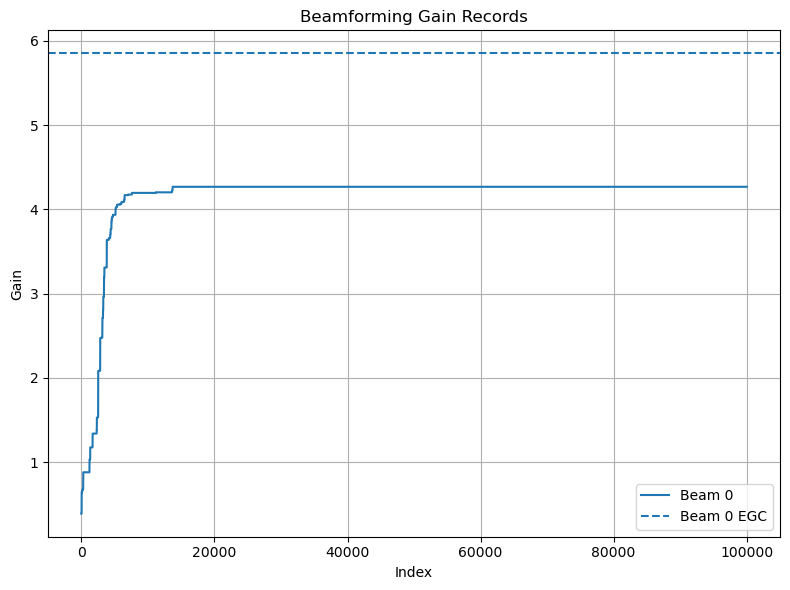

In [122]:
beam_index = 0  #beam index to plot

plt.figure(figsize=(8, 6))
plt.plot(beams_data[beam_index][:-1], label=f'Beam {beam_index}')
plt.axhline(y=beams_data[beam_index][-1], linestyle='--', 
                label=f'Beam {beam_index} EGC')

plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

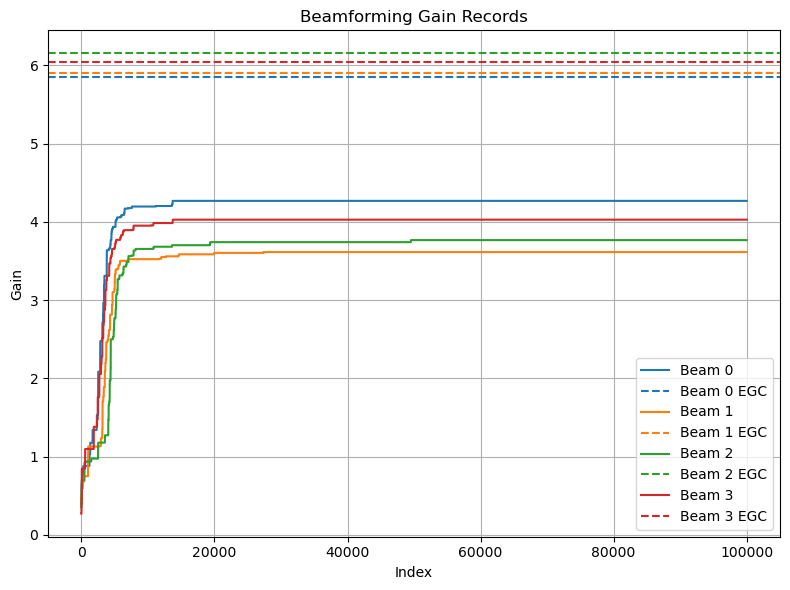

In [123]:
# Plotting
plt.figure(figsize=(8, 6))

for i, data in enumerate(beams_data):
    line, = plt.plot(data[:-1], label=f'Beam {i}')
    color = line.get_color()
    plt.axhline(y=data[-1], color=color, linestyle='--', 
                label=f'Beam {i} EGC')
plt.xlabel('Index')
plt.ylabel('Gain')
plt.title('Beamforming Gain Records')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()